Run "fast" simulations with 8760 annual inputs
===================================

In this section, we will learn how to:

- run timeseries simulations with "fast" mode and in parallel using the ``run_parallel_engine()`` function
- run timeseries simulations with "fast" mode and using the ``PVEngine``

Note: for a better understanding, it might help to read the previous tutorial sections on running timeseries / parallel simulations before going through the following

Imports and settings

In [1]:
# Import external libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import warnings

# Settings
%matplotlib inline
np.set_printoptions(precision=3, linewidth=300)
warnings.filterwarnings('ignore')
# Paths
LOCAL_DIR = os.getcwd()
DATA_DIR = os.path.join(LOCAL_DIR, 'data')
filepath = os.path.join(DATA_DIR, 'test_df_inputs_MET_clearsky_tucson.csv')

## Overview of "fast" mode

The fast mode simulation was implemented in pvfactors v1.0.2. It relies on a mathematical simplification (see Theory section of the documentation) of the problem that assumes that we already know the irradiance incident on all front PV row surfaces and ground surfaces thanks to the Perez model. In this mode, we therefore only calculate view factors from PV row back surfaces to the other ones (therefore decreasing the number of view factors to calculate), and we do not need to solve a linear system of equations anymore for "ordered" PV arrays since the back surfaces don't see each other.  

This is an approximation compared to the "full" mode, since we're not calculating the impact of the multiple reflections on the PV array surfaces. But the initial results show that it still provides a very reasonable estimate of back surface incident irradiance values.

## Running fast simulations in pvfactors

### Get timeseries inputs

In [2]:
def import_data(fp):
    """Import 8760 data to run pvfactors simulation"""
    tz = 'US/Arizona'
    df = pd.read_csv(fp, index_col=0)
    df.index = pd.DatetimeIndex(df.index).tz_convert(tz)
    return df

df_inputs = import_data(filepath)

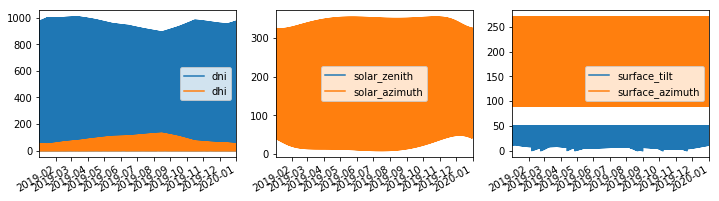

In [3]:
# Plot the data
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
df_inputs[['dni', 'dhi']].plot(ax=ax1)
df_inputs[['solar_zenith', 'solar_azimuth']].plot(ax=ax2)
df_inputs[['surface_tilt', 'surface_azimuth']].plot(ax=ax3)
plt.show()

In [4]:
# Use a fixed albedo
albedo = 0.2

### Prepare PV array parameters

In [5]:
pvarray_parameters = {
    'n_pvrows': 3,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'gcr': 0.4,               # ground coverage ratio
    'rho_front_pvrow': 0.01,  # pv row front surface reflectivity
    'rho_back_pvrow': 0.03    # pv row back surface reflectivity
}

### Run "fast" simulations in parallel with ``run_parallel_engine()``

Running fast timeseries simulations in parallel is done using the ``run_parallel_engine()``, and the procedure is exactly the same with ``run_timeseries_engine()``.
There is only one additional keyword argument that needs to be provided to the function, which is ``fast_mode_pvrow_index``.
In fast mode, the user will be able to calculate rapidly (but with additional approximations) the incident irradiance on the back side of one PV row in the PV array, and the index of that PV row needs to be passed as a keyword argument to ``fast_mode_pvrow_index``.

**First prepare the report builder class**

Just like in the previous tutorial, we need to prepare a report builder that will log the inputs we're interested in during the simulation.

In [6]:
class ReportBuilder(object):
    """A class is required to build reports when running calculations with
    multiprocessing because of python constraints"""
    
    def __init__(self, fast_mode_pvrow_index):
        """Create report builder object for fast mode simulation.
        
        Parameters
        ----------
        fast_mode_pvrow_index : int
            Index of PV row whose back side irradiance we want to report
        """
        self.fast_mode_pvrow_index = fast_mode_pvrow_index
        
    def build(self, report, pvarray):
        # Initialize the report as a dictionary
        if report is None:
            report = {'total_inc_back': []}
        # Add elements to the report
        if pvarray is not None:
            pvrow = pvarray.pvrows[self.fast_mode_pvrow_index]
            report['total_inc_back'].append(
                pvrow.back.get_param_weighted('qinc'))
        else:
            # No calculation was performed, because sun was down
            report['total_inc_back'].append(np.nan)

        return report

    @staticmethod
    def merge(reports):
        """Works for dictionary reports"""
        report = reports[0]
        # Merge other reports
        keys_report = list(reports[0].keys())
        for other_report in reports[1:]:
            for key in keys_report:
                report[key] += other_report[key]
        return report


**Run simulation**

In [7]:
# Choose the number of workers 
n_processes = 2

# Choose center row (index 1) for the fast simulation
fast_mode_pvrow_index = 1

# Instantiate report builder
report_builder = ReportBuilder(fast_mode_pvrow_index)

In [8]:
# import function to run simulations in parallel
from pvfactors.run import run_parallel_engine, run_timeseries_engine

# run simulations in parallel mode
report = run_parallel_engine(report_builder, pvarray_parameters, df_inputs.index, 
                             df_inputs.dni, df_inputs.dhi, 
                             df_inputs.solar_zenith, df_inputs.solar_azimuth, 
                             df_inputs.surface_tilt, df_inputs.surface_azimuth, 
                             albedo, n_processes=n_processes,
                             fast_mode_pvrow_index=fast_mode_pvrow_index)  # new keyword argument

# make a dataframe out of the report
df_report = pd.DataFrame(report, index=df_inputs.index)

100%|██████████| 4380/4380 [00:21<00:00, 212.53it/s]
INFO:pvfactors.run:Parallel calculation elapsed time: 21.9998040199 sec


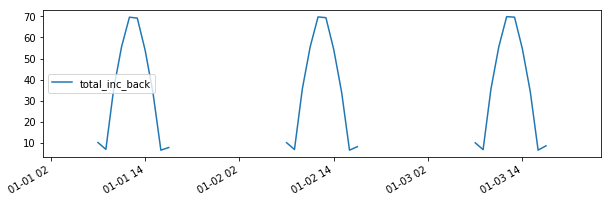

In [9]:
f, ax = plt.subplots(figsize=(10, 3))
df_report.iloc[:72].plot(ax=ax)
plt.show()

### Run "fast" simulations with the PVEngine

The procedure is similar to run fast simulations with the PVEngine.
You only need to provide ``fast_mode_pvrow_index`` as an additional keyword argument to the PV engine at initialization.

In [10]:
# Import PVEngine and OrderedPVArray
from pvfactors.engine import PVEngine
from pvfactors.geometry import OrderedPVArray

# Instantiate PV array
pvarray = OrderedPVArray.init_from_dict(pvarray_parameters)
# Create PV engine, and specify the index of the PV row for fast mode
eng = PVEngine(pvarray, fast_mode_pvrow_index=fast_mode_pvrow_index)

# Fit PV engine to the timeseries data
eng.fit(df_inputs.index, df_inputs.dni, df_inputs.dhi, 
        df_inputs.solar_zenith, df_inputs.solar_azimuth, 
        df_inputs.surface_tilt, df_inputs.surface_azimuth,
        albedo)

In [11]:
# Run timeseries simulations
report = eng.run_all_timesteps(fn_build_report=report_builder.build)

100%|██████████| 8760/8760 [00:36<00:00, 242.15it/s]


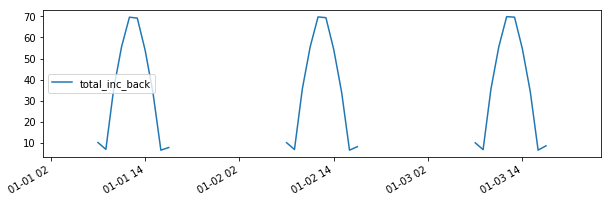

In [12]:
# make a dataframe out of the report
df_report = pd.DataFrame(report, index=df_inputs.index)

# and plot the results
f, ax = plt.subplots(figsize=(10, 3))
df_report.iloc[:72].plot(ax=ax)
plt.show()